In [1]:
import torch
from torch import nn


class Sine(nn.Module):
    def __init__(self, w0=1.):
        super().__init__()
        self.w0 = w0

    def forward(self, x):
        return torch.sin(self.w0 * x)


class BModel(nn.Module):

    def __init__(self, in_coords, out_values, dim, pos_encoding=False):
        super().__init__()
        if pos_encoding:
            posenc = PositionalEncoding(8, 20)
            d_in = nn.Linear(in_coords * 40, dim)
            self.d_in = nn.Sequential(posenc, d_in)
        else:
            self.d_in = nn.Linear(in_coords, dim)
        lin = [nn.Linear(dim, dim) for _ in range(8)]
        self.linear_layers = nn.ModuleList(lin)
        self.d_out = nn.Linear(dim, out_values)
        self.activation = Sine()  # torch.tanh

    def forward(self, x):
        x = self.activation(self.d_in(x))
        for l in self.linear_layers:
            x = self.activation(l(x))
        x = self.d_out(x)
        return x

class VectorPotentialModel(nn.Module):

    def __init__(self, in_coords, dim, pos_encoding=False):
        super().__init__()
        if pos_encoding:
            posenc = PositionalEncoding(8, 20)
            d_in = nn.Linear(in_coords * 40, dim)
            self.d_in = nn.Sequential(posenc, d_in)
        else:
            self.d_in = nn.Linear(in_coords, dim)
        lin = [nn.Linear(dim, dim) for _ in range(8)]
        self.linear_layers = nn.ModuleList(lin)
        self.d_out = nn.Linear(dim, 3)
        self.activation = Sine()  # torch.tanh

    def forward(self, x):
        coord = x
        x = self.activation(self.d_in(x))
        for l in self.linear_layers:
            x = self.activation(l(x))
        a = self.d_out(x)
        #
        jac_matrix = jacobian(a, coord)
        dAy_dx = jac_matrix[:, 1, 0]
        dAz_dx = jac_matrix[:, 2, 0]
        dAx_dy = jac_matrix[:, 0, 1]
        dAz_dy = jac_matrix[:, 2, 1]
        dAx_dz = jac_matrix[:, 0, 2]
        dAy_dz = jac_matrix[:, 1, 2]
        rot_x = dAz_dy - dAy_dz
        rot_y = dAx_dz - dAz_dx
        rot_z = dAy_dx - dAx_dy
        b = torch.stack([rot_x, rot_y, rot_z], -1)
        #
        return b

class PositionalEncoding(nn.Module):
    """
    Positional Encoding of the input coordinates.

    encodes x to (..., sin(2^k x), cos(2^k x), ...)
    k takes "num_freqs" number of values equally spaced between [0, max_freq]
    """

    def __init__(self, max_freq, num_freqs):
        """
        Args:
            max_freq (int): maximum frequency in the positional encoding.
            num_freqs (int): number of frequencies between [0, max_freq]
        """
        super().__init__()
        freqs = 2 ** torch.linspace(0, max_freq, num_freqs)
        self.register_buffer("freqs", freqs)  # (num_freqs)

    def forward(self, x):
        """
        Inputs:
            x: (batch, num_samples, in_features)
        Outputs:
            out: (batch, num_samples, 2*num_freqs*in_features)
        """
        x_proj = x.unsqueeze(dim=-2) * self.freqs.unsqueeze(dim=-1)  # (num_rays, num_samples, num_freqs, in_features)
        x_proj = x_proj.reshape(*x.shape[:-1], -1)  # (num_rays, num_samples, num_freqs*in_features)
        out = torch.cat([torch.sin(x_proj), torch.cos(x_proj)],
                        dim=-1)  # (num_rays, num_samples, 2*num_freqs*in_features)
        return out


def jacobian(output, coords):
    jac_matrix = [torch.autograd.grad(output[:, i], coords,
                                      grad_outputs=torch.ones_like(output[:, i]).to(output),
                                      retain_graph=True,
                                      create_graph=True)[0]
                  for i in range(output.shape[1])]
    jac_matrix = torch.stack(jac_matrix, dim=1)
    return jac_matrix

In [2]:
import os

import numpy as np
import torch
from astropy.io import fits
from matplotlib import pyplot as plt
from torch import nn
from tqdm import tqdm



def load_cube(save_path, device=None, z=None, strides=1, **kwargs):
    if device is None:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    state = torch.load(save_path, map_location=device)
    model = nn.DataParallel(state['model'])
    cube_shape = state['cube_shape']
    z = z if z is not None else cube_shape[2]
    coords = np.stack(np.mgrid[:cube_shape[0]:strides, :cube_shape[1]:strides, :z:strides], -1)
    return load_coords(model, cube_shape, state['spatial_norm'],
                       state['b_norm'], coords, device, **kwargs)

def load_shape(save_path, device=None):
    if device is None:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    state = torch.load(save_path, map_location=device)
    return state['cube_shape']


def load_slice(save_path, z=0, device=None, **kwargs):
    if device is None:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    state = torch.load(save_path, map_location=device)
    model = nn.DataParallel(state['model'])
    cube_shape = state['cube_shape']
    z = z if z is not None else cube_shape[2]
    coords = np.stack(np.mgrid[:cube_shape[0], :cube_shape[1], z:z + 1], -1)
    return load_coords(model, cube_shape, state['spatial_norm'],
                       state['b_norm'], coords, device, **kwargs)


def load_coords_from_state(save_path, coords, device=None, **kwargs):
    if device is None:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    state = torch.load(save_path, map_location=device)
    model = nn.DataParallel(state['model'])
    cube_shape = state['cube_shape']
    return load_coords(model, cube_shape, state['spatial_norm'], state['b_norm'], coords, device,
                       **kwargs)


def load_coords(model, cube_shape, spatial_norm, b_norm, coords, device, batch_size=1000, progress=False):
    assert np.all(coords[..., 0] < cube_shape[0]), 'Invalid x coordinate, maximum is %d' % cube_shape[0]
    assert np.all(coords[..., 1] < cube_shape[1]), 'Invalid x coordinate, maximum is %d' % cube_shape[1]
    assert np.all(coords[..., 2] < cube_shape[2]), 'Invalid x coordinate, maximum is %d' % cube_shape[2]

    def _load(coords):
        # normalize and to tensor
        coords = torch.tensor(coords / spatial_norm, dtype=torch.float32)
        coords_shape = coords.shape
        coords = coords.view((-1, 3))

        cube = []
        it = range(int(np.ceil(coords.shape[0] / batch_size)))
        it = tqdm(it) if progress else it
        for k in it:
            coord = coords[k * batch_size: (k + 1) * batch_size]
            coord = coord.to(device)
            coord.requires_grad = True
            cube += [model(coord).detach().cpu()]

        cube = torch.cat(cube)
        cube = cube.view(*coords_shape).numpy()
        b = cube * b_norm
        return b
    if isinstance(model, VectorPotentialModel) or \
            (isinstance(model, nn.DataParallel) and isinstance(model.module, VectorPotentialModel)):
        return _load(coords)
    else:
        with torch.no_grad():
            return _load(coords)



def save_fits(vec, path, prefix, meta_info={}):
    hdu = fits.PrimaryHDU(vec[..., 0].T)
    for i, v in meta_info.items():
        hdu.header[i] = v
    hdul = fits.HDUList([hdu])
    x_path = os.path.join(path, '%s_Bx.fits' % prefix)
    hdul.writeto(x_path)

    hdu = fits.PrimaryHDU(vec[..., 1].T)
    for i, v in meta_info.items():
        hdu.header[i] = v
    hdul = fits.HDUList([hdu])
    y_path = os.path.join(path, '%s_By.fits' % prefix)
    hdul.writeto(y_path)

    hdu = fits.PrimaryHDU(vec[..., 2].T)
    for i, v in meta_info.items():
        hdu.header[i] = v
    hdul = fits.HDUList([hdu])
    z_path = os.path.join(path, '%s_Bz.fits' % prefix)
    hdul.writeto(z_path)
    return x_path, y_path, z_path


def save_slice(b, file_path, v_min_max=None):
    v_min_max = np.abs(b).max() if v_min_max is None else v_min_max
    plt.imsave(file_path, b.transpose(), cmap='gray', vmin=-v_min_max, vmax=v_min_max, origin='lower')


In [3]:
from tvtk.api import tvtk, write_data
import pyvista as pv 
import os
import numpy as np

def pv_plot(B, vtk_path='./evaluation.vtk', points=((7, 64, 8), (7, 64, 8)), overwrite=False):

    if not os.path.exists(vtk_path) or overwrite:
        dim = B.shape[:-1]
        pts = np.stack(np.mgrid[0:dim[0], 0:dim[1], 0:dim[2]], -1).astype(np.float32)
        pts = pts.transpose(2, 1, 0, 3)
        pts = pts.reshape((-1, 3))
        vectors = B.transpose(2, 1, 0, 3)
        vectors = vectors.reshape((-1, 3))
        sg = tvtk.StructuredGrid(dimensions=dim, points=pts)
        sg.point_data.vectors = vectors
        sg.point_data.vectors.name = 'B'
        write_data(sg, str(vtk_path))

    mesh = pv.read(vtk_path)
    xindmax, yindmax, zindmax = mesh.dimensions
    xcenter, ycenter, zcenter = mesh.center

    p = pv.Plotter()
    p.add_mesh(mesh.outline())

    sargs_B = dict(
        title='Bz [G]',
        title_font_size=15,
        height=0.25,
        width=0.05,
        vertical=True,
        position_x = 0.05,
        position_y = 0.05,
    )
    dargs_B = dict(
        scalars='B', 
        component=2, 
        clim=(-150, 150), 
        scalar_bar_args=sargs_B, 
        show_scalar_bar=False, 
        lighting=False
    )
    p.add_mesh(mesh.extract_subset((0, xindmax, 0, yindmax, 0, 0)), 
            cmap='gray', **dargs_B)

    def draw_streamlines(pts):
        stream, src = mesh.streamlines(
            return_source=True,
            start_position = pts,
            integration_direction='both',
            max_time=1000,
        )
        # print(pts)
        key = pts[0]*pts[1] + (pts[0]//pts[1]) + (pts[0] - pts[1])
        # print(key)
        np.random.seed(key)
        colors = np.random.rand(3)
        # if pts[0] == 16 and pts[1] == 48:
        #     colors = 'white'
        # print(colors)
        p.add_mesh(stream.tube(radius=0.2), lighting=False, color=colors)
        p.add_mesh(src, point_size=7, color=colors)

    xrange = points[0]
    yrange = points[1]
    for i in np.arange(*xrange):
        for j in np.arange(*yrange):
            try: 
                draw_streamlines((i, j, 0))
            except:
                pass
                # print(i, j)

    p.camera_position = 'xy'
    p.show_bounds()
    # p.add_title(title)

    return p

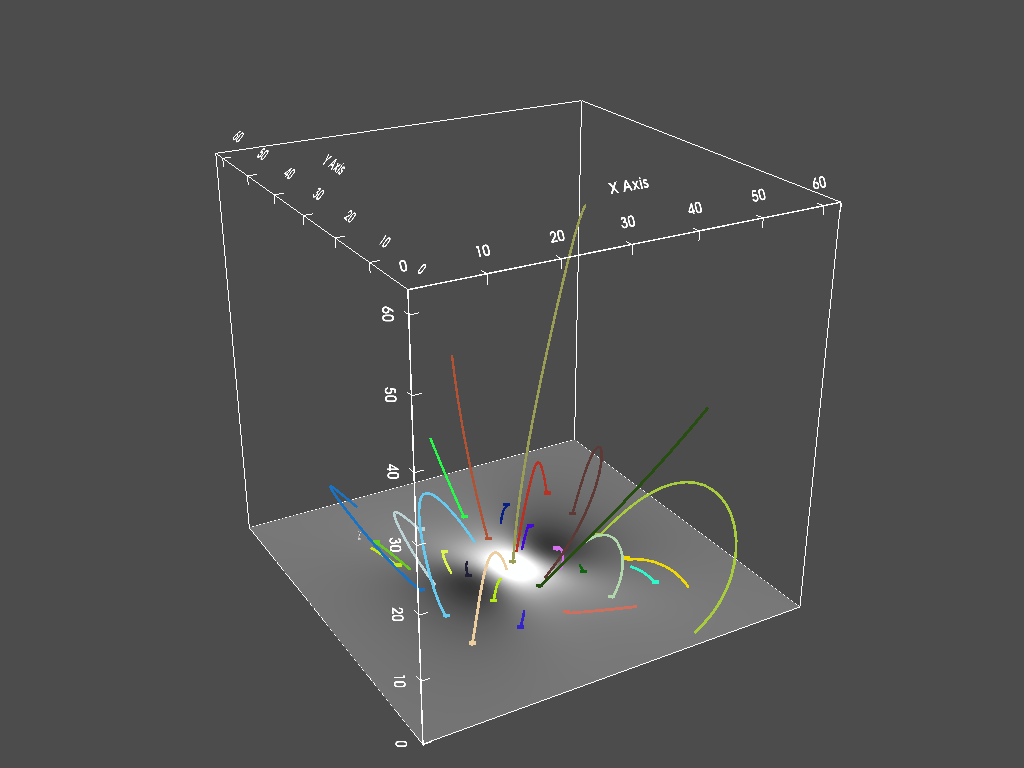

In [18]:
b = np.load('b.npy')
p = pv_plot(b, vtk_path='b.vtk', points=((16, 49, 8), (16, 49, 8)))
p.camera_position = 'xz'
p.camera.azimuth = -30
p.camera.elevation = 25
p.show(jupyter_backend='static')

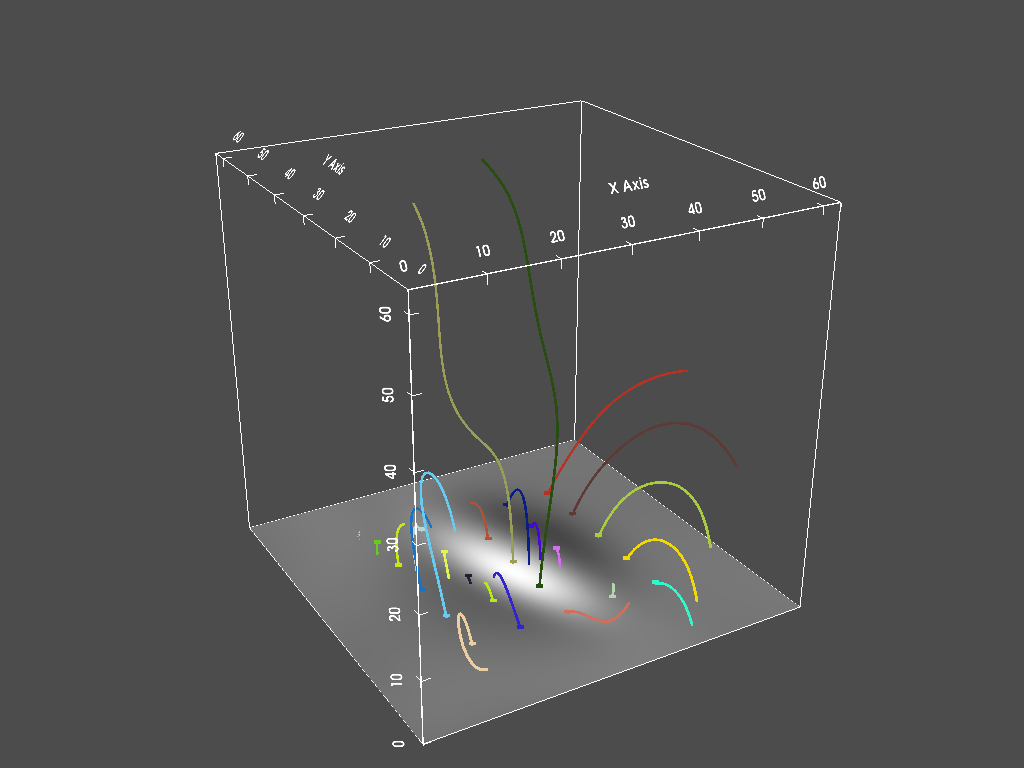

In [15]:
B = load_cube("/home/tensor/workspace/pinn_study/fields_000899.nf2")
p = pv_plot(B, vtk_path='B_000899.vtk', points=((16, 49, 8), (16, 49, 8)))
p.camera_position = 'xz'
p.camera.azimuth = -30
p.camera.elevation = 25
p.show(jupyter_backend='static')

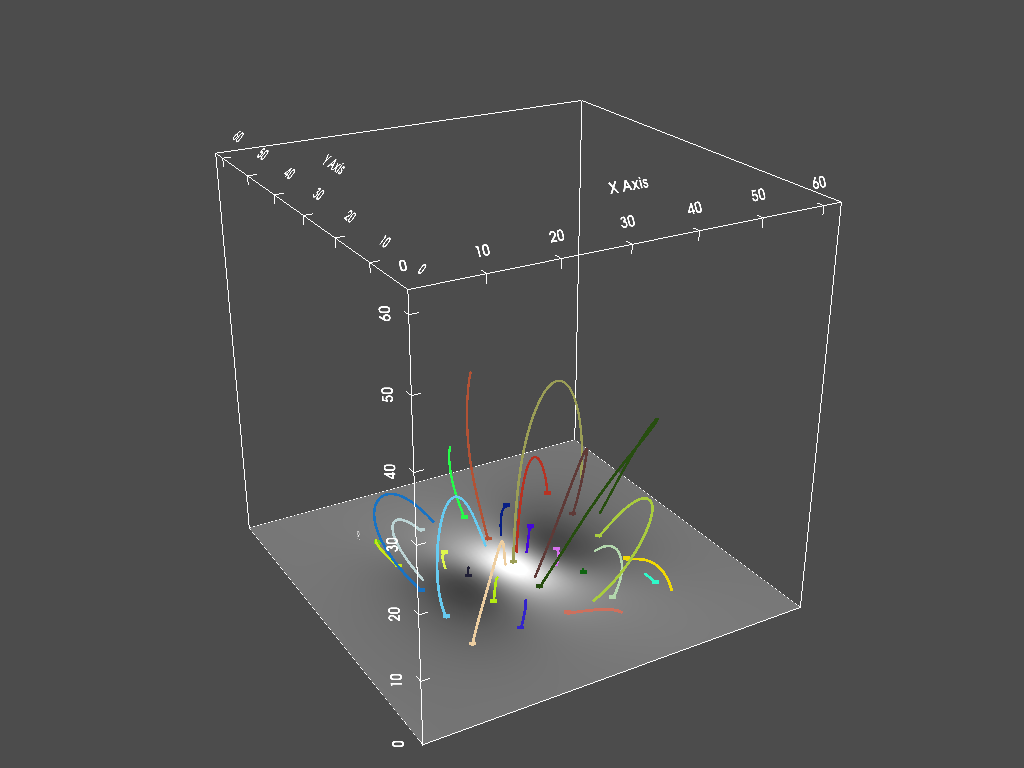

In [16]:
B = load_cube("/home/tensor/workspace/pinn_study/fields_049999.nf2")
p = pv_plot(B, vtk_path='B_049999.vtk', points=((16, 49, 8), (16, 49, 8)))
p.camera_position = 'xz'
p.camera.azimuth = -30
p.camera.elevation = 25
p.show(jupyter_backend='static')

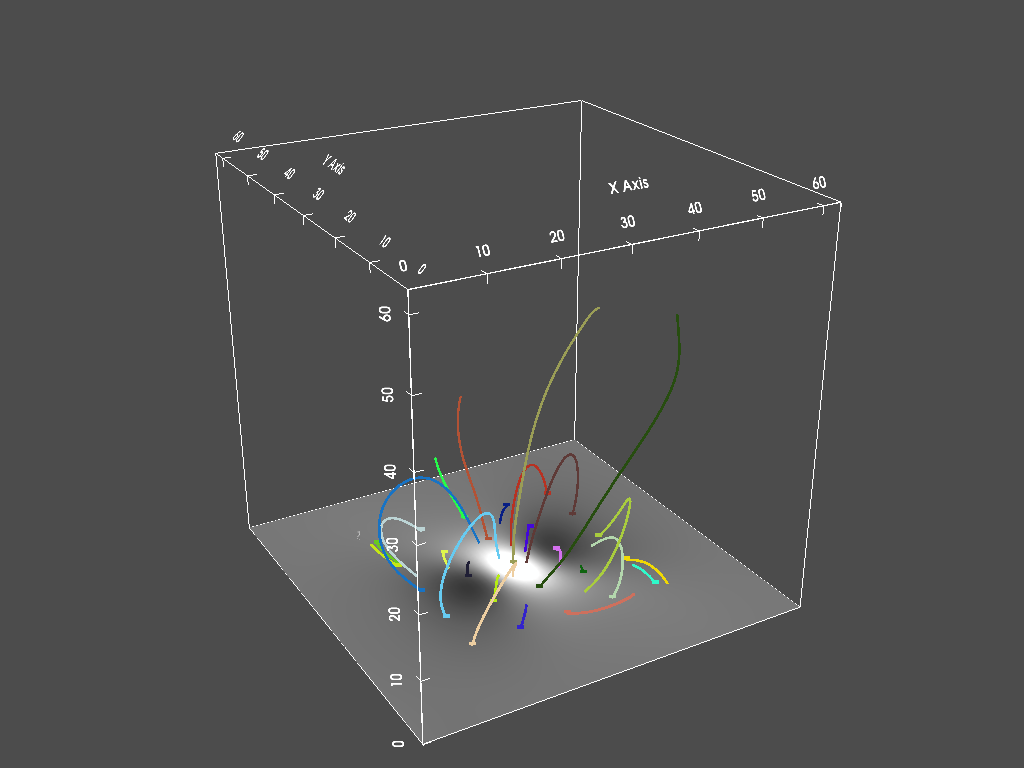

In [19]:
B = load_cube("/home/tensor/workspace/pinn_study/fields_006899.nf2")
p = pv_plot(B, vtk_path='B_006899.vtk', points=((16, 49, 8), (16, 49, 8)))
p.camera_position = 'xz'
p.camera.azimuth = -30
p.camera.elevation = 25
p.show(jupyter_backend='static')